In [27]:
#importing os, shutil and glob for copying concrete images from raw folder to the new structure which is 
#required for ImageDataGenerator.flow_from_directory
import os
import shutil
import glob
import cv2
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
%matplotlib inline

#import keras and different type of layers for for defining CNN models
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.metrics import Precision, Recall

from sklearn.decomposition import PCA

In [28]:
def getDataDic():
    baseDir = 'data'
    dic = {}
    train_crack_path = os.listdir(os.path.join(baseDir, 'train/defect/'))
    train_crack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'train/defect/', path)), (64, 400)) for path in train_crack_path]
    dic['train_crack'] = train_crack

    train_uncrack_path = os.listdir(os.path.join(baseDir, 'train/no defect/'))
    train_uncrack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'train/no defect/', path)), (64, 400)) for path in train_uncrack_path]
    dic['train_uncrack'] = train_uncrack

    test_crack_path = os.listdir(os.path.join(baseDir, 'test/defect/'))
    test_crack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'test/defect/', path)), (64, 400)) for path in test_crack_path]
    dic['test_crack'] = test_crack

    test_uncrack_path = os.listdir(os.path.join(baseDir, 'test/no defect/'))
    test_uncrack = [cv2.resize(cv2.imread(os.path.join(baseDir, 'test/no defect/', path)), (64, 400)) for path in test_uncrack_path]
    dic['test_uncrack'] = test_uncrack
    
    return dic

In [29]:
def transformDataToApplyPca(dic):
    training_images_list = dic['train_crack'] + dic['train_uncrack']
    y_train = []
    for i in range(len(dic['train_crack'])):
        y_train.append(0)
    for i in range(len(dic['train_uncrack'])):
        y_train.append(1)

    testing_images_list = dic['test_crack'] + dic['test_uncrack']
    y_test = []
    for i in range(len(dic['test_crack'])):
        y_test.append(0)
    for i in range(len(dic['test_uncrack'])):
        y_test.append(1)

    temp1 = list(zip(training_images_list, y_train))
    random.shuffle(temp1)
    training_images_list, y_train = zip(*temp1)

    temp2 = list(zip(testing_images_list, y_test))
    random.shuffle(temp2)
    testing_images_list, y_test = zip(*temp2)

    training_images = np.array(training_images_list)
    testing_images = np.array(testing_images_list)
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    return (training_images, testing_images, y_train, y_test)

In [30]:
def convertImagesDataFrom3dTo1d(training_images , testing_images):
    #Now let's reshape images to 1-d
    training_data = training_images.reshape((len(training_images), 64*400*3))
    testing_data = testing_images.reshape((len(testing_images), 64*400*3))

    return (training_data, testing_data)

In [31]:
def returnKwith99Info(variance):
    k = 0
    currentSum = 0
    total = sum(variance)
    
    while(currentSum/total) <=  0.99:
        currentSum += variance[k]
        k += 1
    return k

In [32]:
def applyPcaAndFindSuitableK(training_data, testing_data):
    pca = PCA(n_components=1000)
    pca.fit(training_data)
    
    k = returnKwith99Info(pca.explained_variance_)
    
    pca = PCA(n_components=k)
    transformed_training_data = pca.fit_transform(training_data)
    
    transformed_testing_data = pca.transform(testing_data)
    
    return (transformed_training_data, transformed_testing_data)

In [33]:
def addExtraDimForConv1D(training_data, testing_data):
    training_data = np.expand_dims(training_data, axis=2)
    testing_data = np.expand_dims(testing_data, axis=2)
    
    return (training_data, testing_data)

In [34]:
def getModel(k):
    model = Sequential()
    
    model.add(Conv1D(filters=6, kernel_size=5, activation='relu', input_shape=(k, 1)))
    model.add(AveragePooling1D(pool_size=2, strides=2))

    model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
    model.add(AveragePooling1D(pool_size=2, strides=2))
    
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    model.add(Dense(120))
    model.add(Activation('relu'))
    model.add(Dense(units=84))
    model.add(Activation('relu'))

    model.add(Dense(1)) # this our output layer (since this is binary classification of cracked or uncracked, we use only one unit in output layer).
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
    
    return model

In [35]:
data_loading_start_time = time.time()
dic = getDataDic()
print(len(dic['train_crack']), len(dic['train_uncrack']), len(dic['test_crack']), len(dic['test_uncrack']))
data_loading_finish_time = time.time()
data_loading_time_taken = data_loading_finish_time - data_loading_start_time
print('Data loaded in {:.0f}m {:.0f}s'.format(data_loading_time_taken // 60, data_loading_time_taken % 60))

4999 4426 1667 1476
Data loaded in 1m 27s


In [36]:
#spearate training, testing, validation and visualization images from dictionary of whole images
training_images, testing_images, y_train, y_test = transformDataToApplyPca(dic)
print('Training images = ', len(training_images), ' ', len(y_train))
print('Testing images = ', len(testing_images), ' ', len(y_test))

Training images =  9425   9425
Testing images =  3143   3143


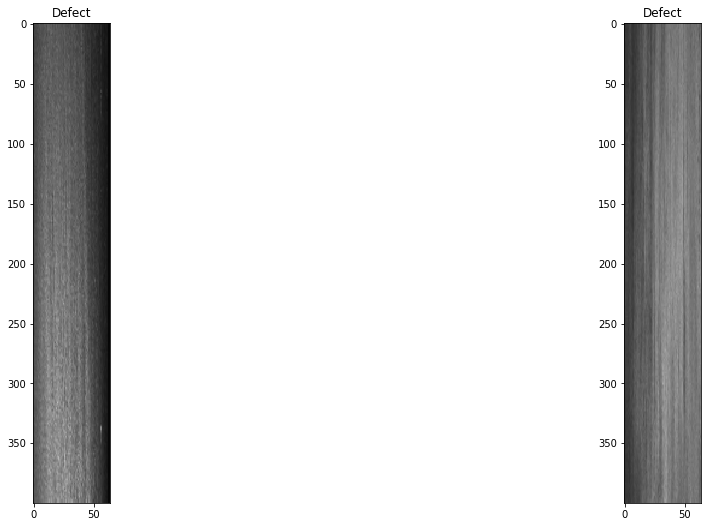

In [37]:
fig = plt.figure(figsize=(30, 30))
for i in range(0, 2, 1):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(training_images[i])
    if(y_train[i] == 0):
        ax.set_title('Defect')
    else:
        ax.set_title('No-Defect')
plt.show()

In [38]:
training_data, testing_data = convertImagesDataFrom3dTo1d(training_images, testing_images)


start_time = time.time()
transformed_training_data, transformed_testing_data = applyPcaAndFindSuitableK(training_data, testing_data)
finish_time = time.time()
time_taken = finish_time - start_time
print('PCA applied in {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))


transformed_training_data, transformed_testing_data = addExtraDimForConv1D(transformed_training_data, transformed_testing_data)
print('Number of features which contains 99% of total information : ', transformed_training_data.shape[1])

PCA applied in 5m 55s
Number of features which contains 99% of total information :  639


In [47]:
model = getModel(transformed_training_data.shape[1])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 635, 6)            36        
_________________________________________________________________
average_pooling1d_5 (Average (None, 317, 6)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 313, 16)           496       
_________________________________________________________________
average_pooling1d_6 (Average (None, 156, 16)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 156, 16)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 78, 16)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1248)             

In [48]:
start_time_training = time.time() 
verbose, epochs, batch_size = 0, 20, 32
history = model.fit(
    transformed_training_data,
    y_train,
    epochs=epochs,
    validation_data=(transformed_testing_data, y_test)
)
finish_time_training = time.time()
time_taken_training = finish_time_training - start_time_training
print('\n')
print('Training complete in {:.0f}m {:.0f}s'.format(time_taken_training // 60, time_taken_training % 60))

Train on 9425 samples, validate on 3143 samples
Epoch 1/20
9425/9425 [==============================] - 2s 191us/step - loss: 2.2114 - accuracy: 0.5909 - precision_3: 0.5621 - recall_3: 0.5829 - val_loss: 0.6951 - val_accuracy: 0.5943 - val_precision_3: 0.5443 - val_recall_3: 0.8374
Epoch 2/20
9425/9425 [==============================] - 2s 159us/step - loss: 0.7021 - accuracy: 0.6288 - precision_3: 0.6021 - recall_3: 0.6175 - val_loss: 0.5946 - val_accuracy: 0.6688 - val_precision_3: 0.6469 - val_recall_3: 0.6491
Epoch 3/20
9425/9425 [==============================] - 2s 191us/step - loss: 0.6319 - accuracy: 0.6522 - precision_3: 0.6336 - recall_3: 0.6150 - val_loss: 0.5598 - val_accuracy: 0.7016 - val_precision_3: 0.6624 - val_recall_3: 0.7432
Epoch 4/20
9425/9425 [==============================] - 1s 159us/step - loss: 0.5957 - accuracy: 0.6718 - precision_3: 0.6564 - recall_3: 0.6319 - val_loss: 0.5514 - val_accuracy: 0.7133 - val_precision_3: 0.7170 - val_recall_3: 0.6436
Epoch 5/

In [49]:
np.save('my_history_2.npy',history.history)

In [50]:
_, accuracy, precision, recall = model.evaluate(transformed_testing_data, y_test, batch_size=batch_size, verbose=verbose)
print(' accuracy : ', accuracy, '\n', 'precision : ', precision, '\n', 'recall : ', recall)

 accuracy :  0.7540566325187683 
 precision :  0.7108578085899353 
 recall :  0.8028455376625061


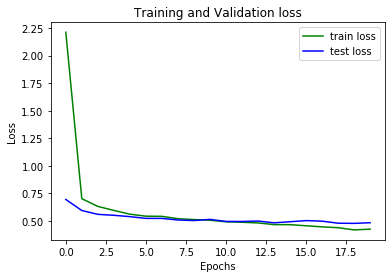

In [51]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,20)
plt.plot(epochs, loss_train, 'g', label='train loss')
plt.plot(epochs, loss_val, 'b', label='test loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

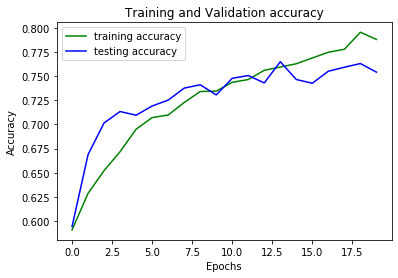

In [52]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(0,20)
plt.plot(epochs, accuracy_train, 'g', label='training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='testing accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

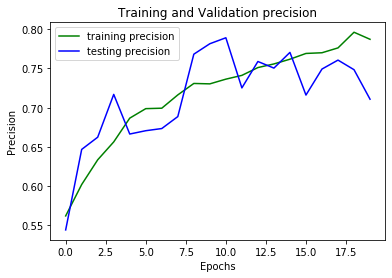

In [54]:
precision_train = history.history['precision_3']
precision_val = history.history['val_precision_3']
epochs = range(0,20)
plt.plot(epochs, precision_train, 'g', label='training precision')
plt.plot(epochs, precision_val, 'b', label='testing precision')
plt.title('Training and Validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

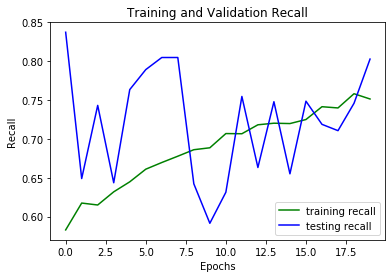

In [55]:
recall_train = history.history['recall_3']
recall_val = history.history['val_recall_3']
epochs = range(0,20)
plt.plot(epochs, recall_train, 'g', label='training recall')
plt.plot(epochs, recall_val, 'b', label='testing recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()